test the trained neural network 'despeckling filter' on inner Sydney

In [1]:
#imports
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight
#setup radar dc
dc = datacube.Datacube(config='radar.conf')

In [57]:
#approx coordinate window for sydney
query = {
'x' : (151.16,151.23),
'y' : (-33.89, -33.82),
'time' : ('2016-09-01','2019-01-01')
}

sydneySAR = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

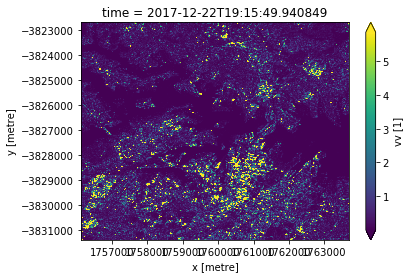

In [3]:
sydneySAR.vv.isel(time=37).plot(robust=True)

In [6]:
syd_test_scene = sydneySAR.vv.isel(time=slice(0,50),x=slice(0,256),y=slice(0,256))

In [7]:
syd_test_scene = syd_test_scene.mean(dim='time')

In [8]:
syd_test_scene = syd_test_scene.where(~np.isnan(syd_test_scene),0)

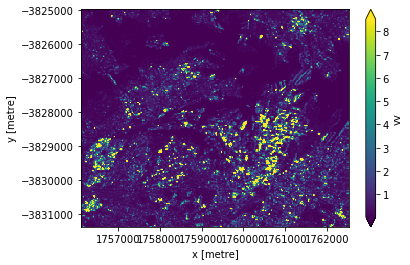

In [10]:
syd_test_scene.plot(robust=True)

In [26]:
syd_test_nparr = syd_test_scene.data

In [31]:
np.std(syd_test_nparr)

8.981333

In [41]:
syd_test_nparr=np.reshape(syd_test_nparr,(1,256,256,1))

In [72]:
normie_test = (syd_test_nparr-syd_test_nparr.mean())/syd_test_nparr.std()

In [36]:
import deepSAR.denoising_models

In [39]:
model = deepSAR.denoising_models.conv_denoise_autoenc(pretrained_weights='denoise_autoenc-60-0.21.hdf5', input_size=(256,256,1), train = False, output_noisy=False)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/keras/layers/core.py:665: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 256, 256, 1)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [73]:
cleaned = model.predict(normie_test)

In [74]:
cleaned = cleaned.reshape(256,256)

In [47]:
cleaned.shape

(256, 256)

In [75]:
cleaned_da = xr.DataArray(cleaned)

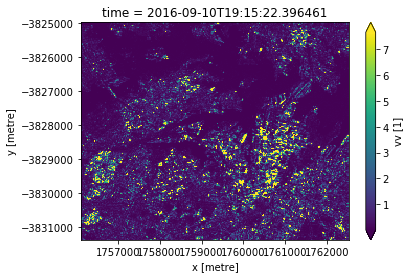

In [55]:
syd_test_scene.plot(robust=True)

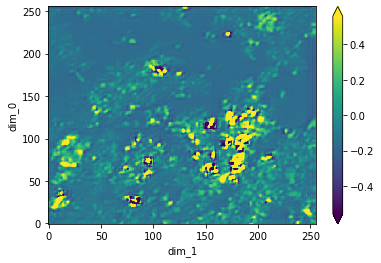

In [84]:
cleaned_da.plot(robust=True,cmap='viridis')

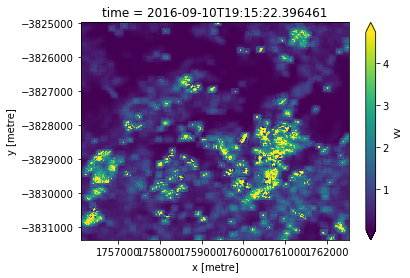

In [71]:
classic_clean.plot(robust = True)

In [64]:
(cleaned_da<-0.8).sum()

<xarray.DataArray ()>
array(868)

In [5]:
classic_clean = rf.denoise(sydneySAR.isel(time=slice(0,10),x=slice(0,256),y=slice(0,256))).vv

In [11]:
cbrquery = {
    'x' : (149.11,149.19),
    'y' : (-35.33,-35.27),
    'time' : ('2016-09-01','2019-06-01')
}

cbrSAR = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **cbrquery)

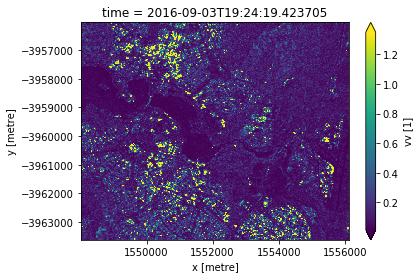

In [12]:
cbrSAR.isel(time=0).vv.plot(robust=True)

In [13]:
cbrSAR.isel(time=0).vv.shape

(304, 324)

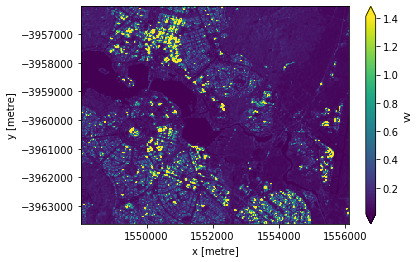

In [14]:
cbrSAR.isel(time=slice(0,60)).mean(dim='time').vv.plot(robust=True)

In [15]:
cbr_scene = cbrSAR.isel(time=0,x=slice(0,256),y=slice(-257,-1))

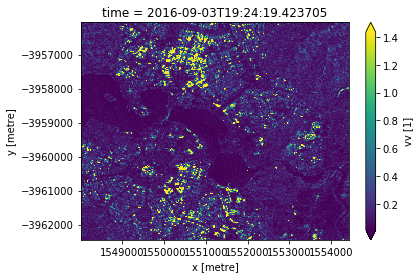

In [16]:
cbr_scene.vv.plot(robust=True)

In [36]:
cbr_tarr = cbr_scene.vv.where(~np.isnan(cbr_scene.vv),0).data

In [37]:
cbr_tarr.shape

(256, 256)

In [38]:
cbr_tarr = np.reshape(cbr_tarr,(1,256,256,1))
mu = cbr_tarr.mean()
sigma = cbr_tarr.std()

In [39]:
cbr_tarr = (cbr_tarr - cbr_tarr.mean())/cbr_tarr.std()

In [7]:
import sys
sys.path.append('/home/118/rlt118/dea-notebooks/deepSAR/')

In [8]:
import deepSARscripts.denoising_models

Using Theano backend.


In [23]:
model = deepSARscripts.denoising_models.unet_autoenc(pretrained_weights='unet_autoenc-59-0.18.hdf5', input_size=(256,256,1), train = False, output_noisy=False)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/keras/layers/core.py:665: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 256, 256, 1)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [40]:
cbr_out = xr.DataArray(np.reshape(model.predict(cbr_tarr),(256,256)),dims=['y','x'])

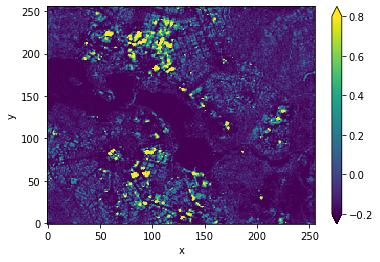

In [41]:
cbr_out.plot(robust=False,cmap='viridis',vmin=-0.2,vmax=0.8)

In [42]:
cbr_out = cbr_out*sigma+mu

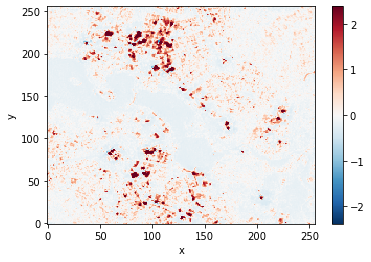

In [47]:
cbr_out.plot()

In [44]:
mu

0.2599056

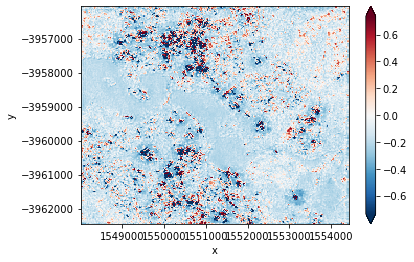

In [57]:
(cbr_out-cbr_comp).plot(robust=True)

In [55]:
cbr_comp = cbrSAR.isel(time=slice(0,60),x=slice(0,256),y=slice(-257,-1)).mean(dim='time').vv